In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df =  pd.read_csv("creditcard.csv")

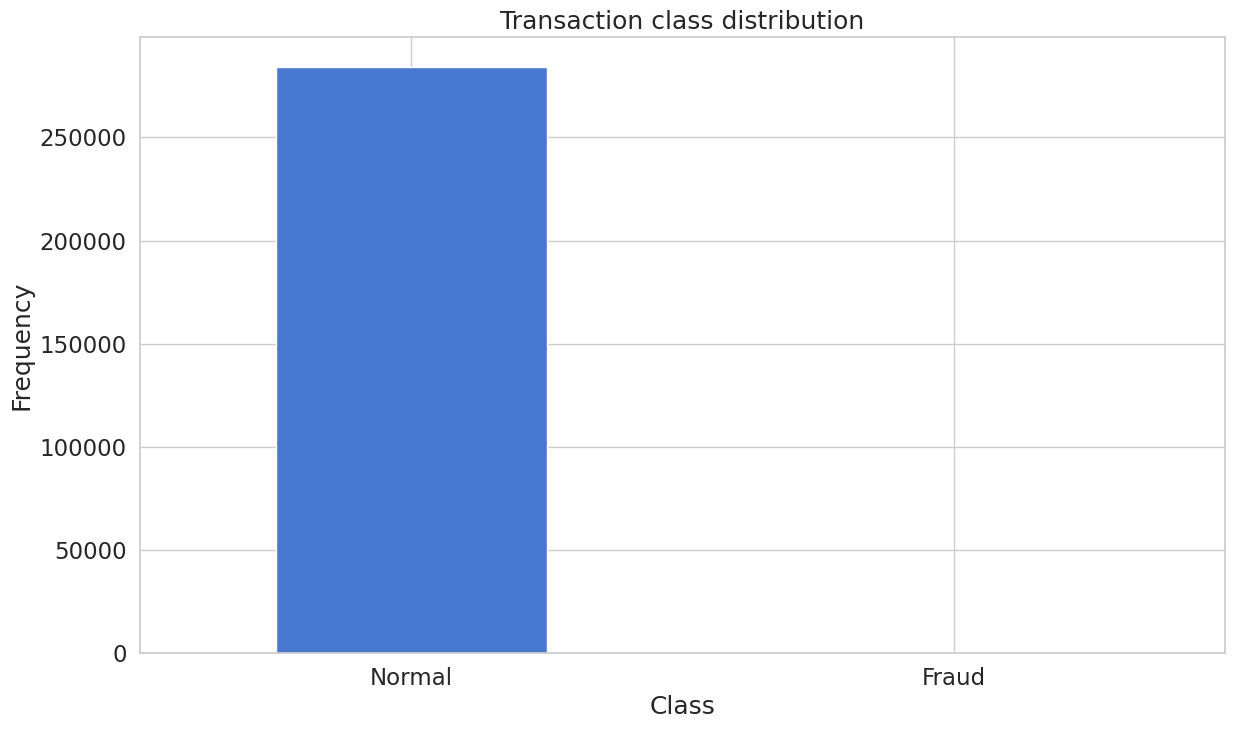

In [4]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


In [6]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [8]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [9]:
nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min',
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7108/7108 [==============================] - 23s 3ms/step - loss: 0.8111 - accuracy: 0.5992 - val_loss: 0.7979 - val_accuracy: 0.6483
Epoch 2/10
  80/7108 [..............................] - ETA: 13s - loss: 0.7618 - accuracy: 0.6281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 20s 3ms/step - loss: 0.7598 - accuracy: 0.6484 - val_loss: 0.7834 - val_accuracy: 0.6579
Epoch 3/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7497 - accuracy: 0.6631 - val_loss: 0.7752 - val_accuracy: 0.6682
Epoch 4/10
7108/7108 [==============================] - 18s 2ms/step - loss: 0.7442 - accuracy: 0.6725 - val_loss: 0.7662 - val_accuracy: 0.6789
Epoch 5/10
7108/7108 [==============================] - 18s 2ms/step - loss: 0.7231 - accuracy: 0.6858 - val_loss: 0.7470 - val_accuracy: 0.6963
Epoch 6/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7152 - accuracy: 0.6949 - val_loss: 0.7461 - val_accuracy: 0.6968
Epoch 7/10
7108/7108 [==============================] - 20s 3ms/step - loss: 0.7125 - accuracy: 0.6986 - val_loss: 0.7422 - val_accuracy: 0.7042
Epoch 8/10
7108/7108 [==============================] - 17s 2ms/step - loss: 0.7104 - accuracy: 0.7011 - val_loss: 0.7408 - val_accuracy: 0.7

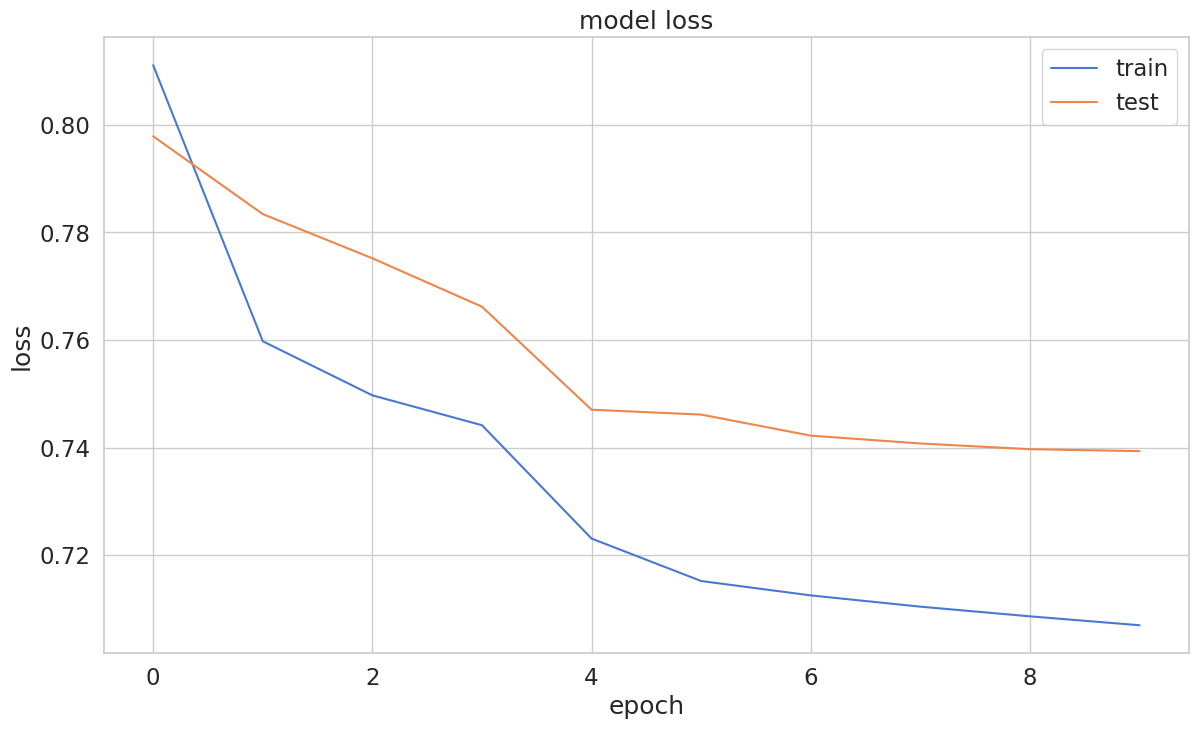

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [11]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 3s 1ms/step


In [12]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [13]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.738648,0.001720
std,3.470821,0.041443
min,0.067718,0.000000
25%,0.244875,0.000000
50%,0.384967,0.000000
75%,0.610541,0.000000
max,272.006554,1.000000


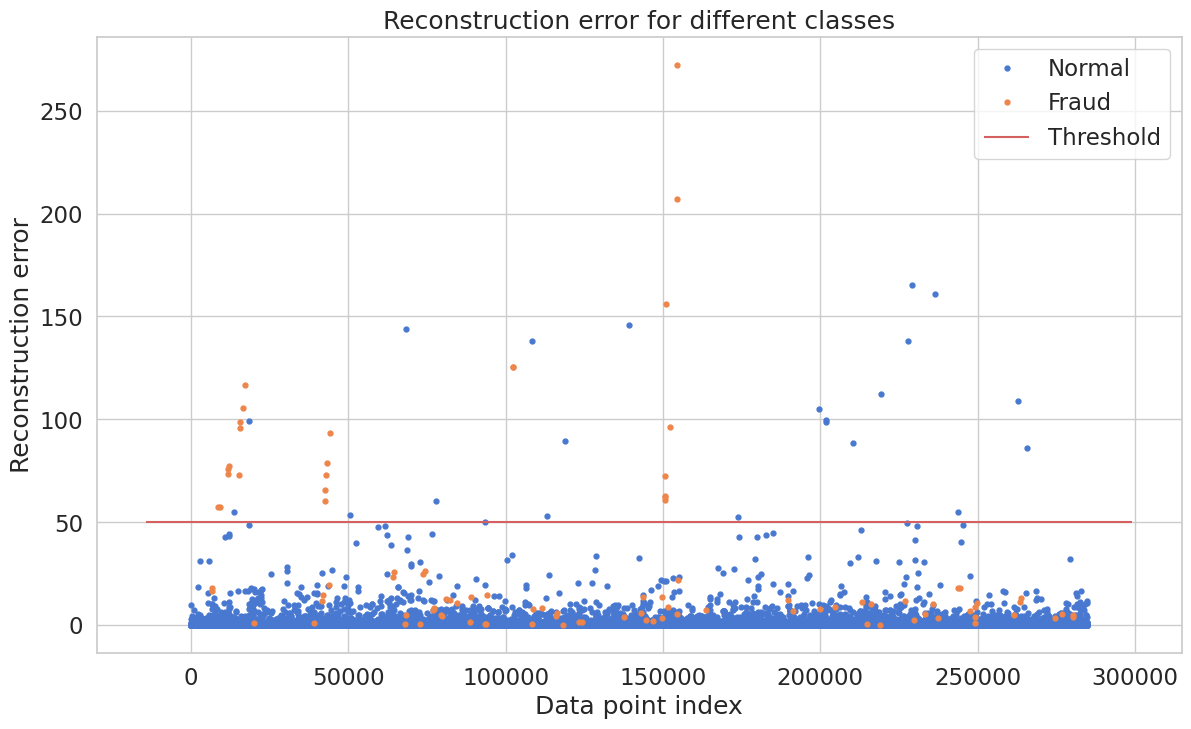

In [14]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [15]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

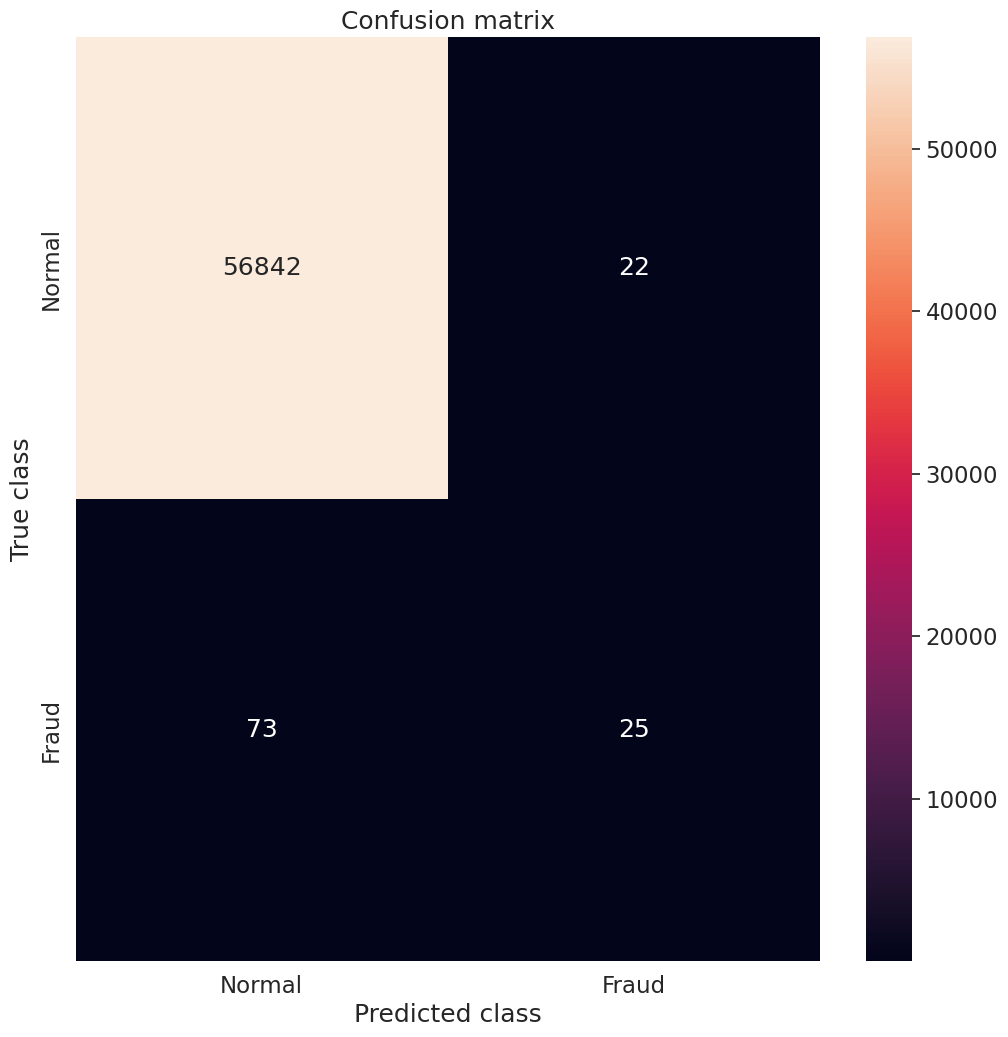

In [16]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
error_df['pred'] = y_pred

In [ ]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred']))
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983497770443454
Recall: 0.25510204081632654
Precision: 0.5434782608695652
